# explore gold and silver using FRED data

In [1]:
library(tidyverse)
library(ggthemes)
library(odbc)
library(plutoR)
library(quantmod)
library(PerformanceAnalytics)
options("scipen"=999)

source("goofy/misc.common.R")
source("goofy/plot.common.R")
source("config.R")

fred<-Fred()
indices<-Indices()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘lubridate’

The follow

first, lets check what kind of data is available on the FRED for gold

In [2]:
goldFred <- fred$Meta() %>% inner_join(fred$TimeSeries(), by = 'SERIES_ID') %>%
    filter(NAME %like% '%gold%') %>%
    group_by(SERIES_ID, TICKER, NAME) %>%
    summarize(MIN_TS = min(TIME_STAMP), MAX_TS = max(TIME_STAMP)) %>%
    select(SERIES_ID, TICKER, NAME, MIN_TS, MAX_TS)

print(data.frame(goldFred))

Warning message:
“Missing values are always removed in SQL.
Use `MIN(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”Warning message:
“Missing values are always removed in SQL.
Use `MAX(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

    SERIES_ID           TICKER
1 -2147252007 GOLDAMGBD228NLBM
2 -2147252006 GOLDAMGBD229NLBM
3 -2147252005 GOLDAMGBD230NLBM
4 -2147252004 GOLDPMGBD228NLBM
5 -2147252003 GOLDPMGBD229NLBM
6 -2147252002 GOLDPMGBD230NLBM
7 -2147170851           GVZCLS
8 -2147170841         VXGDXCLS
9 -2147170839          VXGSCLS
                                                                                          NAME
1   Gold Fixing Price 10:30 A.M. (London time) in London Bullion Market, based in U.S. Dollars
2 Gold Fixing Price 10:30 A.M. (London time) in London Bullion Market, based in British Pounds
3          Gold Fixing Price 10:30 A.M. (London time) in London Bullion Market, based in Euros
4    Gold Fixing Price 3:00 P.M. (London time) in London Bullion Market, based in U.S. Dollars
5  Gold Fixing Price 3:00 P.M. (London time) in London Bullion Market, based in British Pounds
6           Gold Fixing Price 3:00 P.M. (London time) in London Bullion Market, based in Euros
7                        

In [3]:
seriesIdGold <- -2147252004 #use the afternoon USD fix
goldDf <- data.frame(fred$TimeSeries() %>% filter(SERIES_ID == seriesIdGold, TIME_STAMP >= as.Date('1995-01-01')) %>% 
    select(TIME_STAMP, VAL))
goldDf$TIME_STAMP <- as.Date(goldDf$TIME_STAMP)

fredDetailsGold <- data.frame(goldFred %>% filter(SERIES_ID == seriesIdGold))

print(nrow(goldDf))
print(head(goldDf))

goldXts <- xts(goldDf$VAL, goldDf$TIME_STAMP)

[1] 6136
  TIME_STAMP   VAL
1 1995-01-03 380.9
2 1995-01-04 375.6
3 1995-01-05 375.3
4 1995-01-06 375.2
5 1995-01-09 372.4
6 1995-01-10 374.1


In [4]:
### plot the price of gold in USD

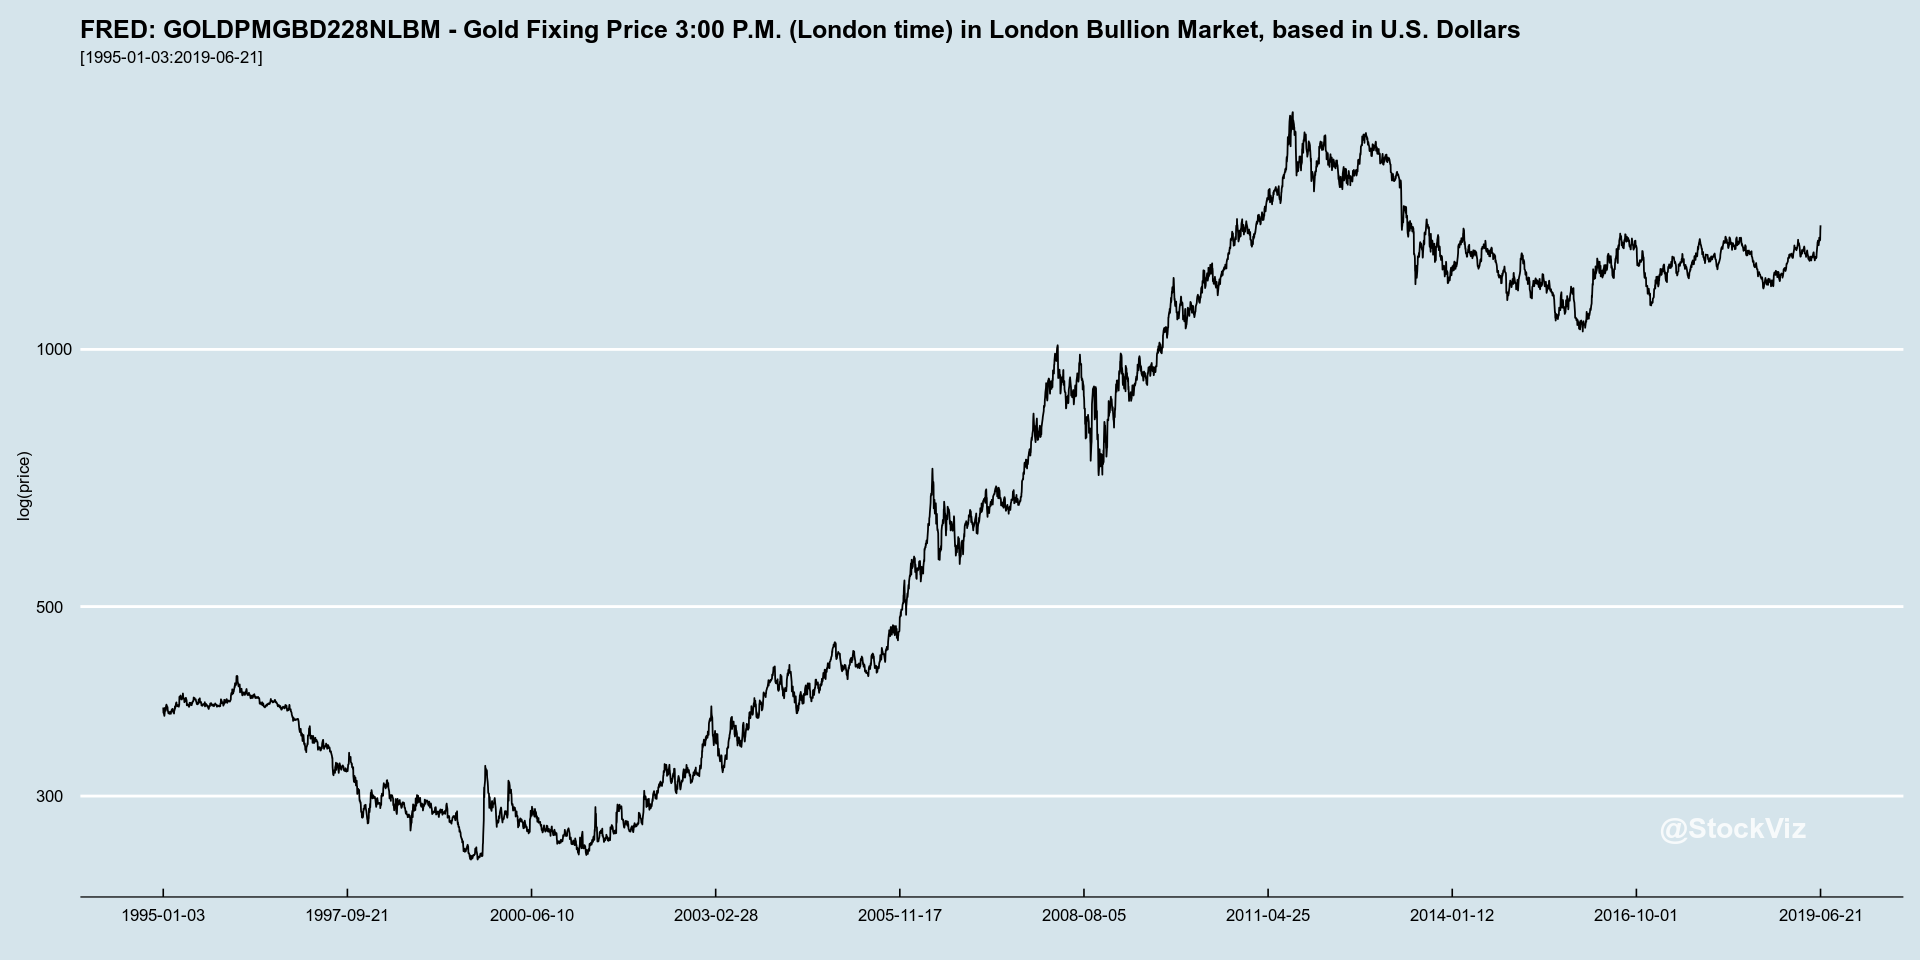

In [5]:
firstDate <- min(goldDf$TIME_STAMP)
lastDate <- max(goldDf$TIME_STAMP)
xAxisTicks <- seq(from=firstDate, to=lastDate, length.out=10)

options(repr.plot.width=16, repr.plot.height=8)

ggplot(goldDf, aes(x=TIME_STAMP, y=VAL)) +
    theme_economist() +
    #theme(text = element_text(size = 3), element_line(size = 0.1)) +
    geom_line() +
    scale_y_log10() +
    scale_x_date(breaks = xAxisTicks) +
    labs(x='', y='log(price)', color='', title=sprintf("FRED: %s - %s", fredDetailsGold$TICKER[1], fredDetailsGold$NAME[1]), 
         subtitle=sprintf("[%s:%s]", firstDate, lastDate)) +
    annotate("text", x=lastDate, y=min(goldDf$VAL, na.rm=T), label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

### NIFTY 50 vs. Gold

The NIFTY 50 TR index has been around since 1999. Translate that index to USD and plot monthly returns vs. gold.

In [6]:
trIndex <- data.frame(indices$NseTimeSeries() %>%
    filter(NAME == "NIFTY 50 TR" && TIME_STAMP >= '2000-01-01' && TIME_STAMP <= lastDate) %>%
    select(TIME_STAMP, CLOSE))

trXts <- xts(trIndex$CLOSE, as.Date(trIndex$TIME_STAMP))

In [7]:
seriesIdUsdInr <- -2147478748
usdInrDf <- data.frame(fred$TimeSeries() %>% filter(SERIES_ID == seriesIdUsdInr, TIME_STAMP >= as.Date('2000-01-01')) %>% 
    select(TIME_STAMP, VAL))
usdInrDf$TIME_STAMP <- as.Date(usdInrDf$TIME_STAMP)

fredDetailsUsdInr <- data.frame(fred$Meta() %>% filter(SERIES_ID == seriesIdUsdInr))

print(nrow(usdInrDf))
print(head(usdInrDf))

usdInrXts <- xts(usdInrDf$VAL, usdInrDf$TIME_STAMP)

[1] 4882
  TIME_STAMP   VAL
1 2000-01-03 43.55
2 2000-01-04 43.55
3 2000-01-05 43.55
4 2000-01-06 43.55
5 2000-01-07 43.55
6 2000-01-10 43.55


In [8]:
allXts <- merge(trXts, usdInrXts)
#holidays don't match up, so carry the USDINR forward.
allXts[,2] <- na.locf(allXts[,2])
allXts <- na.omit(allXts)
allXts <- merge(allXts, allXts[,1]/allXts[,2])

In [9]:
#end-of months don't match, so force them to a common on
monthlies <- merge(Common.NormalizeMonthlyDates(monthlyReturn(allXts[,3])), Common.NormalizeMonthlyDates(monthlyReturn(allXts[,2])))
names(monthlies) <-c('TR', 'USDINR')

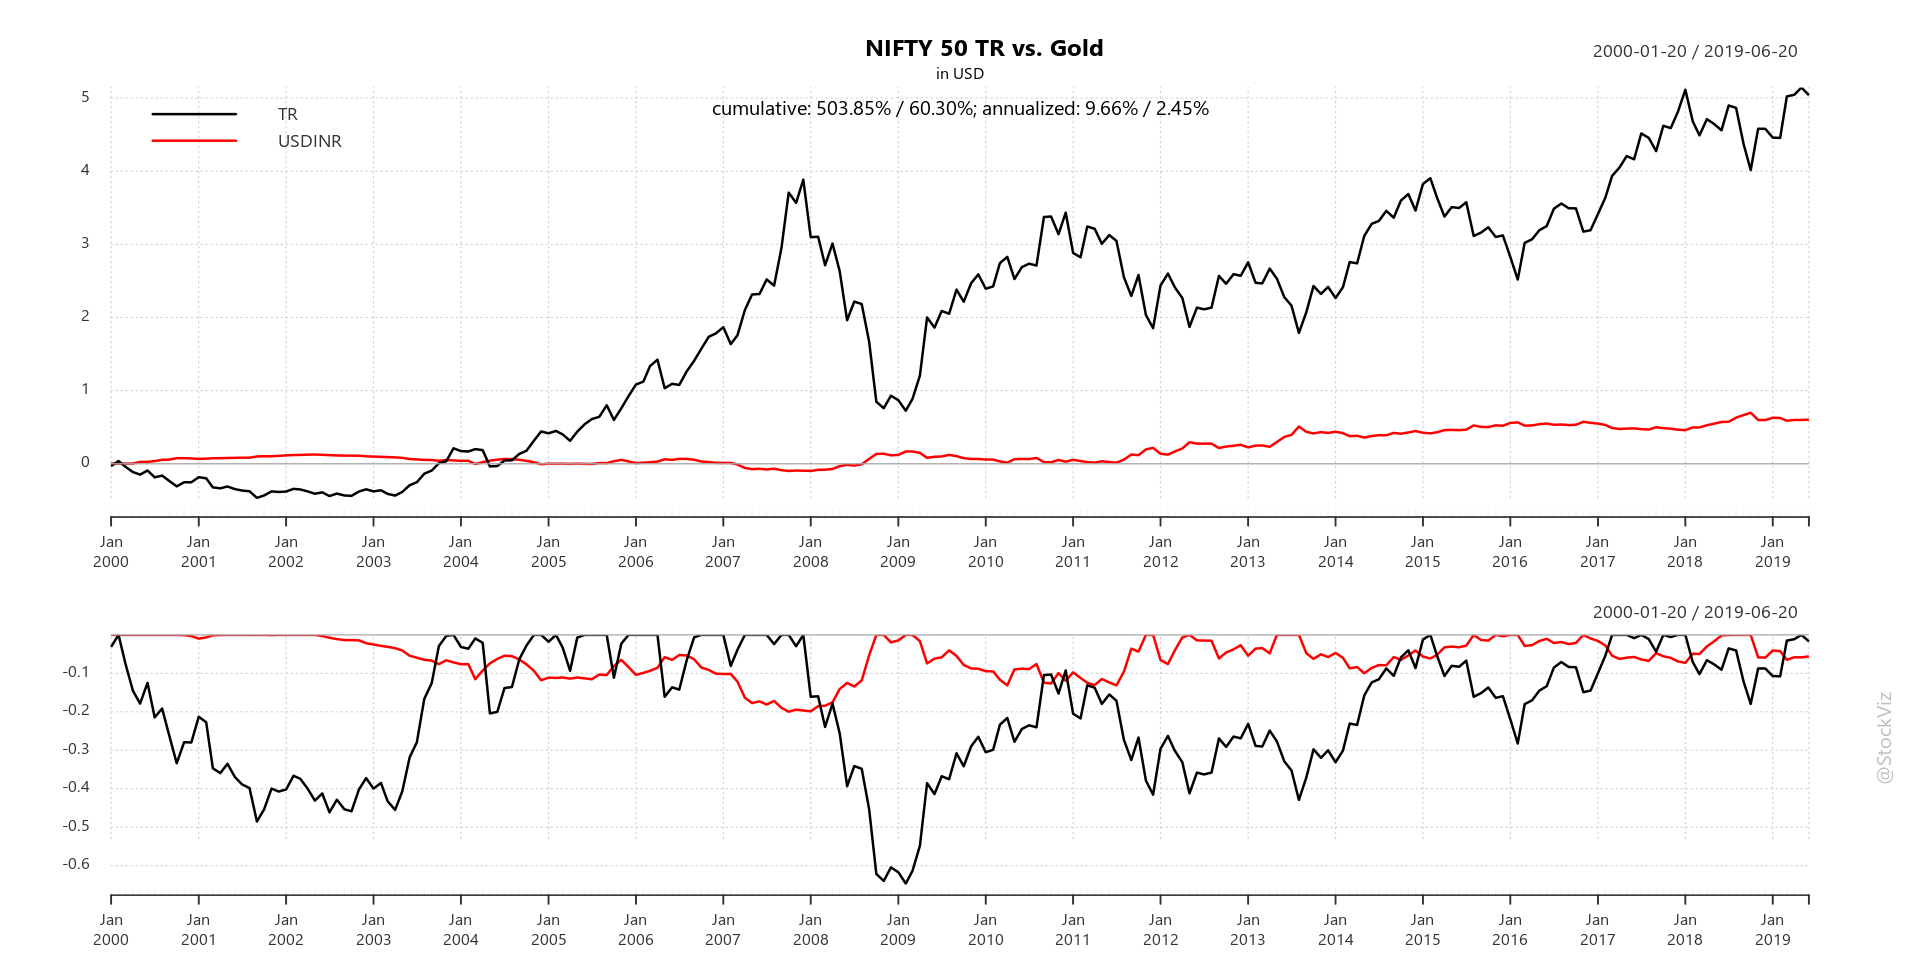

In [10]:
Common.PlotCumReturns(monthlies, "NIFTY 50 TR vs. Gold", "in USD")